In [1]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")   # type: ignore

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PYG_GRAPHS = torch.load("data/processed/pyg_graphs_384D.pt", weights_only=False)

PyTorch version: 2.5.1
CUDA available: True
CUDA version: 12.4


In [2]:
## HELPER FUNCTIONS FOR CREATING AND TRAINING MODEL
import importlib
import src.models.multitask_debate_gnn
importlib.reload(src.models.multitask_debate_gnn)

from src.models.multitask_debate_gnn import ECCConv, MultitaskDebateGNN, train_gnn_live, plot_cv_losses
from torch_geometric.nn import GCNConv, SAGEConv

from typing import Dict, Any, Type, Optional

def create_and_describe_model(model_args: Dict[str, Any], model_class: Type[MultitaskDebateGNN] = MultitaskDebateGNN) -> Optional[MultitaskDebateGNN]:
    """Build the model from args, print a summary, and return the instance (or None on failure)."""
    try:
        model = model_class(**model_args)
        print("Model created:")
        print(f"   Architecture: {[type(conv).__name__ for conv in model.convs]}")
        print(f"   Mode: {model.mode}")
        print(f"   Input dim: {model_args['in_dim']}")
        print(f"   Hidden dim: {model_args['hidden_dim']}")
        print(f"   Embedding dim: {model_args['emb_dim']}")
        print(f"   Number of layers: {model_args['num_layers']}")

        # Count parameters
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print("\nModel Statistics:")
        print(f"   Total parameters: {total_params:,}")
        print(f"   Trainable parameters: {trainable_params:,}")
        print(f"   Model size: ~{total_params * 4 / 1024**2:.1f} MB")

        # Show model structure
        print("\nModel Structure:")
        print(model)
        return model

    except Exception as e:
        print(f"Error creating model: {e}")
        import traceback
        traceback.print_exc()
        return None
    
def run_cv_training(
    graph_data,
    model_args: dict,
    train_args: dict,
    model_class: Type[MultitaskDebateGNN] = MultitaskDebateGNN,
    live_plot: bool = False,):
    """
    Runs cross-validation training with cleanup and plotting.
    Returns (model, results, cv_history) or (None, None, None) on failure.
    """
    import gc, traceback
    import torch

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    try:
        model, results, cv_history = train_gnn_live(
            all_graphs=getattr(graph_data, "pyg_graphs", graph_data),
            model_args=model_args,
            train_args=train_args,
            model_class=model_class,
            live_plot=live_plot,
        )
        plot_cv_losses(cv_history=cv_history)
        return model, results, cv_history
    except Exception as e:
        print(f"Training error: {e}")
        traceback.print_exc()
        return None, None, None

In [12]:
# BASE MODEL AND TRAINING ARGS (shared across all variants)
BASE_MODEL_ARGS = dict(
    in_dim = 384,
    hidden_dim = 256,
    emb_dim = 128,
    neg_attr_weight = 0.3,
    dropout = 0.15,
)

ECC_KWARGS = dict(
    edge_mlp_dropout = 0.1,
    keep_prob = 0.8,
    conf_dim = 1,
    stance_dim = 3
)

BASE_TRAIN_ARGS = dict(
    epochs = 30,
    lr = 0.001,
    patience = 6,
    min_delta = 3e-4,
    neg_sample_ratio = 0.5,
    temp_reg_weight = 0.1,
    val_n_last = 1, # or val_pct_last = 0.25 (pick either one)
    val_gap_n = 1,
)

# To store cv results later
TRAIN_RESULTS = {
    "3-GCN": None,
    "3-SAGE": None,
    "2-SAGE-1-ECC": None,
}
TRAINED_MODELS = {
    "3-GCN": None,
    "3-SAGE": None,
    "2-SAGE-1-ECC": None,
}

In [13]:
# DEFINE VARIANTS ARGS

# 1. 3-GCN -> Link Only
# Take base args for link only
_3gcn_margs = BASE_MODEL_ARGS | dict(
    num_layers=3,
    mode="link_only",
    conv_cls=GCNConv
)

# 2. 3-SAGE -> Link Only
# Take base args for linky only
_3sage_margs = BASE_MODEL_ARGS | dict(
    num_layers=3,
    mode="link_only",
    conv_cls=SAGEConv
)

# 3. 2-SAGE-1-ECC -> Full
_2sage_1ecc_F_margs = BASE_MODEL_ARGS | dict(
    num_layers=3,
    mode="full",
    conv_cls_list=[SAGEConv, SAGEConv, ECCConv],
    ecc_kwargs=ECC_KWARGS   # Share ECC args for all with ECC layer
)

### **3-GCN** (Link Only)

Training 3-GCN...

Dataset Overview:
  - Total graphs: 77
  - Device: cuda
  - Training mode: link_only
  - Task weights: Default (1.0 each)
  - Tasks: Link
   + Subreddit 0: 23 graphs | 4,286 nodes | 14,580 edges | Avg: 633.9 edges/graph
   + Stance Dist: [0.414, 0.290, 0.296] (disagree/neutral/agree)
   + Subreddit 1: 10 graphs | 1,910 nodes | 1,425 edges | Avg: 142.5 edges/graph
   + Stance Dist: [0.326, 0.225, 0.449] (disagree/neutral/agree)
   + Subreddit 2: 26 graphs | 4,328 nodes | 4,308 edges | Avg: 165.7 edges/graph
   + Stance Dist: [0.406, 0.283, 0.311] (disagree/neutral/agree)
   + Subreddit 3: 9 graphs | 6,705 nodes | 7,677 edges | Avg: 853.0 edges/graph
   + Stance Dist: [0.359, 0.214, 0.427] (disagree/neutral/agree)
   + Subreddit 4: 9 graphs | 7,022 nodes | 7,296 edges | Avg: 810.7 edges/graph
   + Stance Dist: [0.402, 0.245, 0.353] (disagree/neutral/agree)

Global Statistics:
  - Total nodes: 24,251
  - Total edges: 35,286
  - Avg nodes/graph: 314.9
  - Avg edges/graph

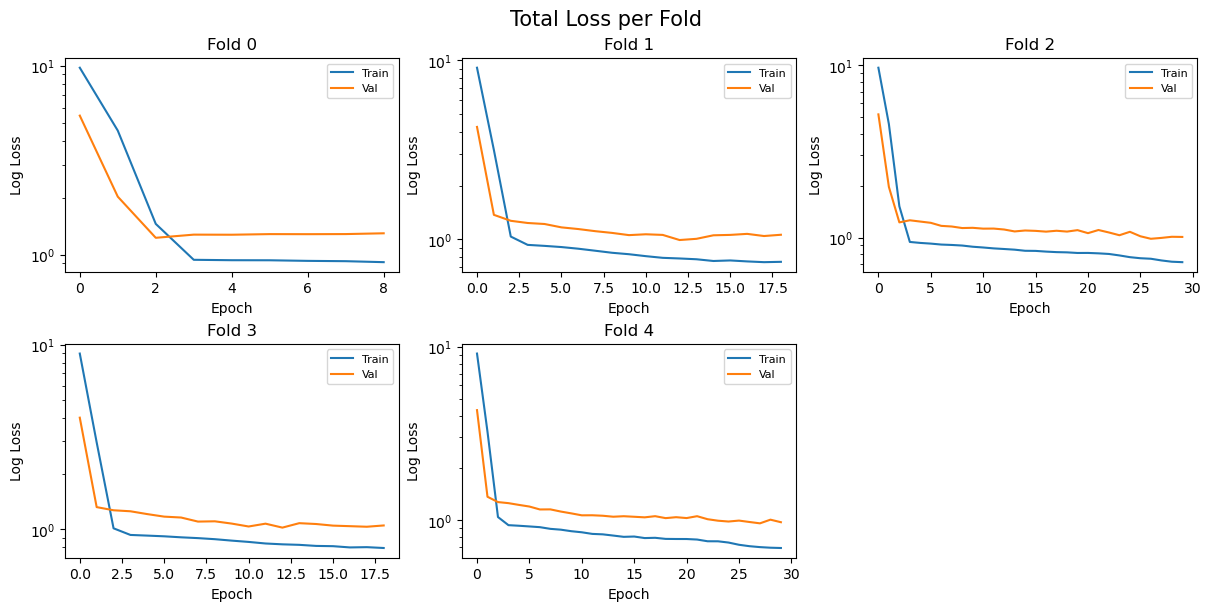

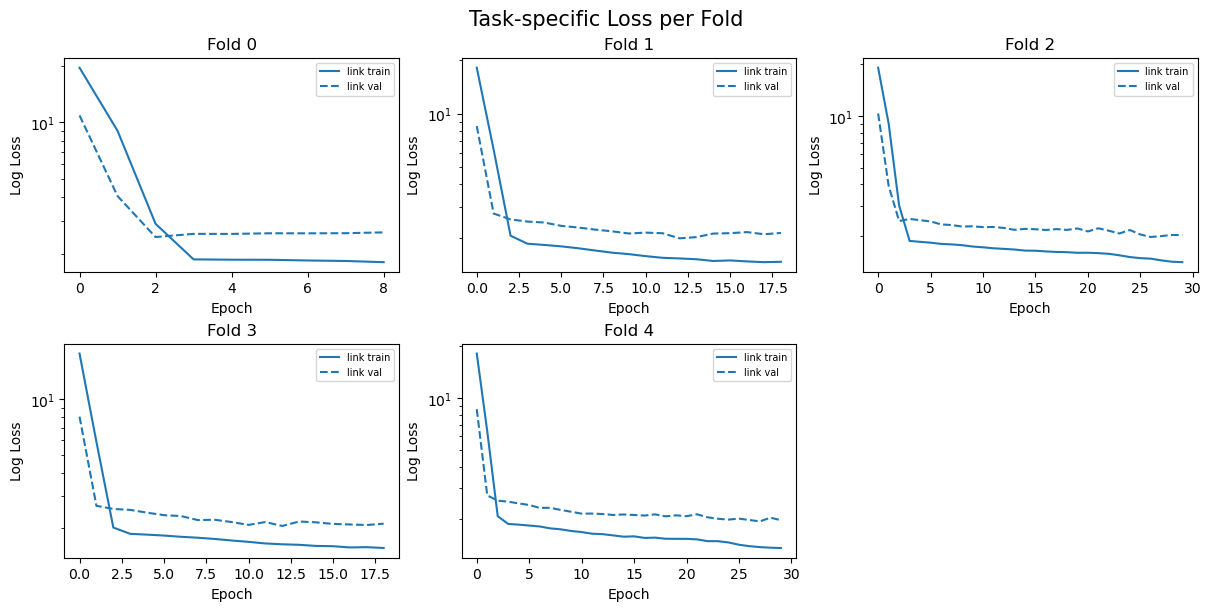

In [14]:
print("Training 3-GCN...")

_3gcn_model, _3gcn_results, _3gcn_cv_history = run_cv_training(
    graph_data = PYG_GRAPHS,
    model_args = _3gcn_margs,
    train_args = BASE_TRAIN_ARGS,
    model_class = MultitaskDebateGNN,
    live_plot = False
)
# Save trained model and result to dict
TRAIN_RESULTS['3-GCN'] = _3gcn_results
TRAINED_MODELS['3-GCN'] = _3gcn_model

### **3-SAGE** (Link Only)

Training 3-SAGE...

Dataset Overview:
  - Total graphs: 77
  - Device: cuda
  - Training mode: link_only
  - Task weights: Default (1.0 each)
  - Tasks: Link
   + Subreddit 0: 23 graphs | 4,286 nodes | 14,580 edges | Avg: 633.9 edges/graph
   + Stance Dist: [0.414, 0.290, 0.296] (disagree/neutral/agree)
   + Subreddit 1: 10 graphs | 1,910 nodes | 1,425 edges | Avg: 142.5 edges/graph
   + Stance Dist: [0.326, 0.225, 0.449] (disagree/neutral/agree)
   + Subreddit 2: 26 graphs | 4,328 nodes | 4,308 edges | Avg: 165.7 edges/graph
   + Stance Dist: [0.406, 0.283, 0.311] (disagree/neutral/agree)
   + Subreddit 3: 9 graphs | 6,705 nodes | 7,677 edges | Avg: 853.0 edges/graph
   + Stance Dist: [0.359, 0.214, 0.427] (disagree/neutral/agree)
   + Subreddit 4: 9 graphs | 7,022 nodes | 7,296 edges | Avg: 810.7 edges/graph
   + Stance Dist: [0.402, 0.245, 0.353] (disagree/neutral/agree)

Global Statistics:
  - Total nodes: 24,251
  - Total edges: 35,286
  - Avg nodes/graph: 314.9
  - Avg edges/grap

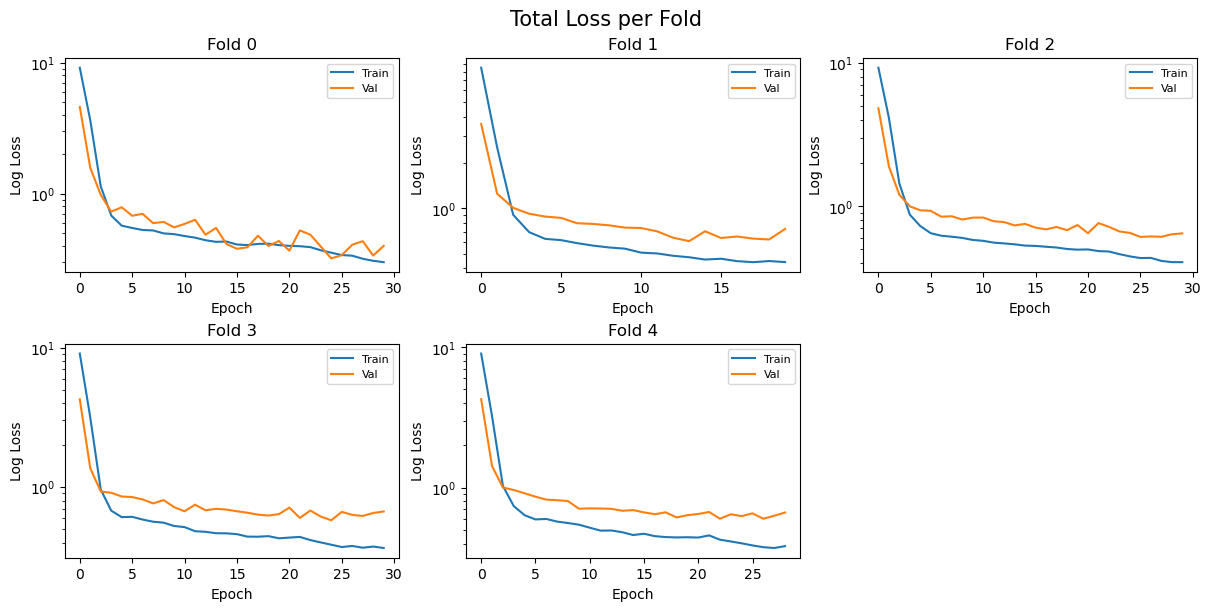

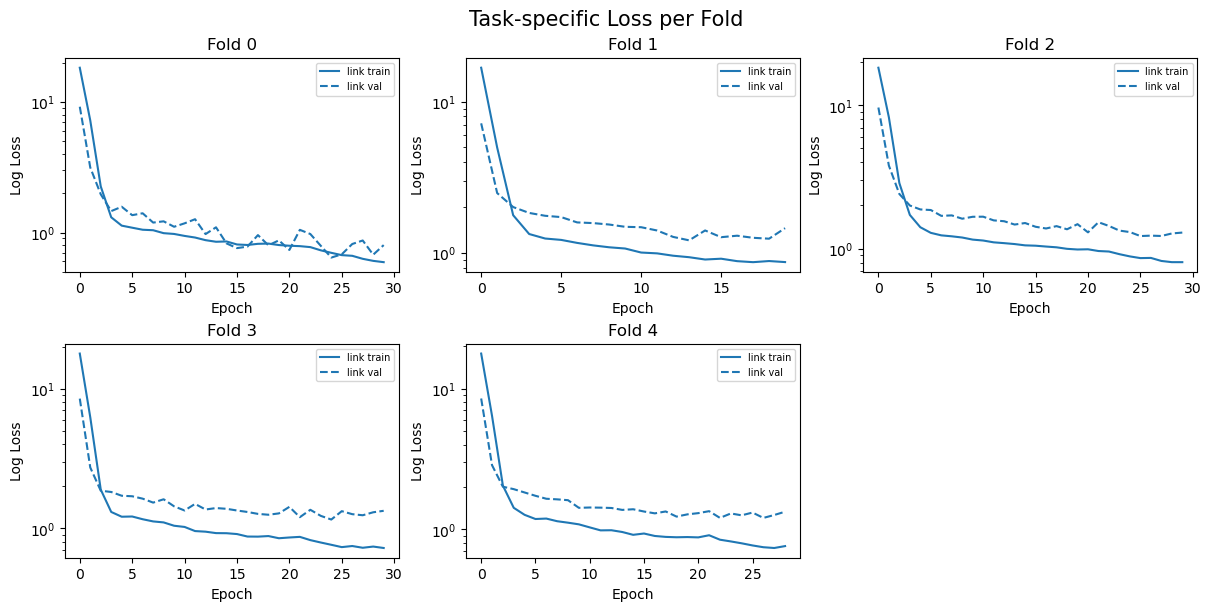

In [15]:
print("Training 3-SAGE...")
_3sage_model, _3sage_results, _3sage_cv_history = run_cv_training(
    graph_data = PYG_GRAPHS,
    model_args = _3sage_margs,
    train_args = BASE_TRAIN_ARGS,
    model_class = MultitaskDebateGNN,
    live_plot = False
)
# Save trained model and result to dict
TRAIN_RESULTS['3-SAGE'] = _3sage_results
TRAINED_MODELS['3-SAGE'] = _3sage_model

### **2-SAGE-1-ECC** (Full)

Training 2-SAGE-1-ECC (Full)...

Dataset Overview:
  - Total graphs: 77
  - Device: cuda
  - Training mode: full
  - Task weights: {'link': 1.0, 'conf': 1.0, 'stance': 1.0}
  - Tasks: Link, Confidence, Stance
   + Subreddit 0: 23 graphs | 4,286 nodes | 14,580 edges | Avg: 633.9 edges/graph
   + Stance Dist: [0.414, 0.290, 0.296] (disagree/neutral/agree)
   + Subreddit 1: 10 graphs | 1,910 nodes | 1,425 edges | Avg: 142.5 edges/graph
   + Stance Dist: [0.326, 0.225, 0.449] (disagree/neutral/agree)
   + Subreddit 2: 26 graphs | 4,328 nodes | 4,308 edges | Avg: 165.7 edges/graph
   + Stance Dist: [0.406, 0.283, 0.311] (disagree/neutral/agree)
   + Subreddit 3: 9 graphs | 6,705 nodes | 7,677 edges | Avg: 853.0 edges/graph
   + Stance Dist: [0.359, 0.214, 0.427] (disagree/neutral/agree)
   + Subreddit 4: 9 graphs | 7,022 nodes | 7,296 edges | Avg: 810.7 edges/graph
   + Stance Dist: [0.402, 0.245, 0.353] (disagree/neutral/agree)

Global Statistics:
  - Total nodes: 24,251
  - Total edges: 3

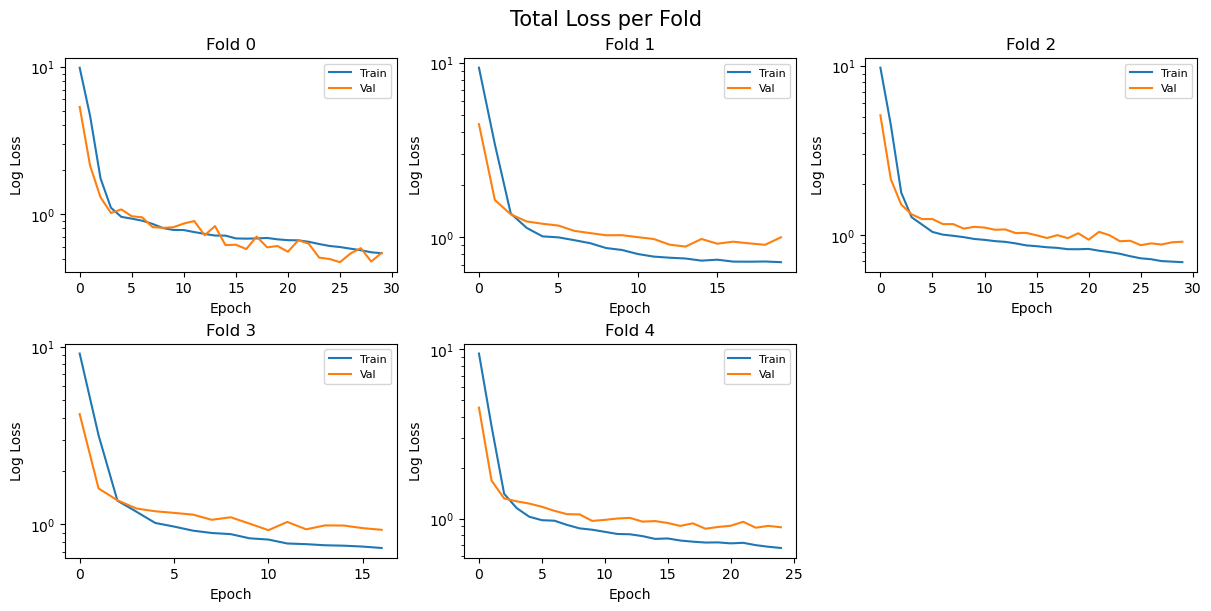

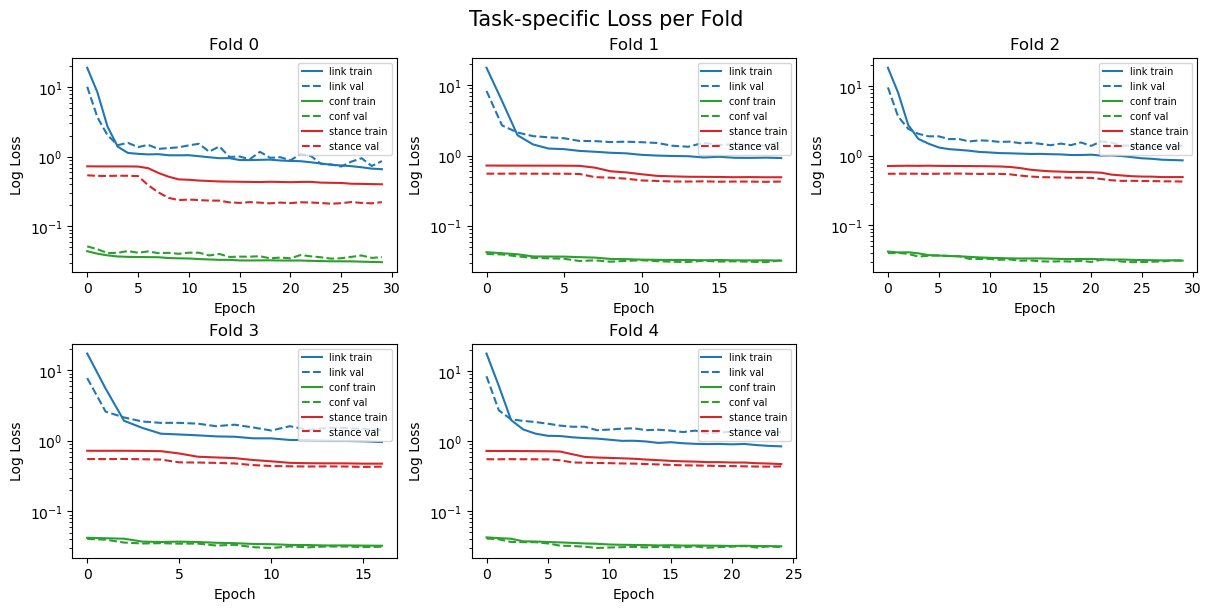

In [ ]:
print("Training 2-SAGE-1-ECC (Full)...")
_2sage_1ecc_F_model, _2sage_1ecc_F_results, _2sage_1ecc_F_cv_history = run_cv_training(
    graph_data = PYG_GRAPHS,
    model_args = _2sage_1ecc_F_margs,
    train_args = BASE_TRAIN_ARGS | dict(
        task_weights = {"link": 1.0, "conf": 1.0, "stance": 1.0}
    ),
    model_class = MultitaskDebateGNN,
    live_plot = False
)
# Save trained model and result to dict
TRAIN_RESULTS['2-SAGE-1-ECC'] = _2sage_1ecc_F_results
TRAINED_MODELS['2-SAGE-1-ECC'] = _2sage_1ecc_F_model

### **FINAL RESULTS**

In [24]:
import pandas as pd

records = []
for variant, fold_dict in TRAIN_RESULTS.items():
    for fold_id, metrics in fold_dict.items():
        rec = {"variant": variant, "fold": fold_id}
        rec.update(metrics)
        records.append(rec)

df = pd.DataFrame.from_records(records)
wide = (df.pivot(index="fold", columns="variant").sort_index())
wide.loc["MEAN"] = wide.mean()
wide = wide.round(3)
wide

link_auc                   conf_mae                  conf_nll  \
variant 2-SAGE-1-ECC  3-GCN 3-SAGE 2-SAGE-1-ECC 3-GCN 3-SAGE 2-SAGE-1-ECC   
fold                                                                        
0              0.830  0.583  0.822        0.346   NaN    NaN        0.703   
1              0.905  0.710  0.908        0.357   NaN    NaN        0.695   
2              0.896  0.758  0.913        0.345   NaN    NaN        0.723   
3              0.875  0.774  0.923        0.340   NaN    NaN        0.728   
4              0.903  0.830  0.915        0.352   NaN    NaN        0.699   
MEAN           0.882  0.731  0.896        0.348   NaN    NaN        0.710   

                       stance_nll                 stance_kl               
variant 3-GCN 3-SAGE 2-SAGE-1-ECC 3-GCN 3-SAGE 2-SAGE-1-ECC 3-GCN 3-SAGE  
fold                                                                      
0         NaN    NaN        0.924   NaN    NaN        0.894   NaN    NaN  
1         NaN    NaN        0.372   NaN    NaN        0.368   NaN    NaN  
2         NaN    NaN        0.557   NaN    NaN        0.555   NaN    NaN  
3         NaN    NaN        0.641   NaN    NaN        0.638   NaN    NaN  
4         NaN    NaN        0.645   NaN    NaN        0.644   NaN    NaN  
MEAN      NaN    NaN        0.628   NaN    NaN        0.620   NaN    NaN

In [25]:
df_mean = df.drop(columns="fold").groupby("variant").mean(numeric_only=True).round(3)
df_mean

,link_auc,conf_mae,conf_nll,stance_nll,stance_kl
variant,,,,,
2-SAGE-1-ECC,0.882,0.348,0.71,0.628,0.62
3-GCN,0.731,NaN,NaN,NaN,NaN
3-SAGE,0.896,NaN,NaN,NaN,NaN
